In [1]:
# Install lsdb and S3 to access PS1 data. And matplotlib for plotting!
%pip install --quiet lsdb s3fs matplotlib


[notice] A new release of pip is available: 24.1 -> 24.2
[notice] To update, run: /astro/users/kmalanch/.virtualenvs/tape/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import dask.distributed
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from lsdb import read_hipscat, from_dataframe

In [3]:
# Define paths to PS1 DR2 catalogs
PS1_PATH = "s3://stpubdata/panstarrs/ps1/public/hipscat"
PS1_OBJECT = f"{PS1_PATH}/otmo"
PS1_DETECTION = f"{PS1_PATH}/detection"

# Define paths to ZTF DR16 Zubercal catalog
ZUBERCAL_PATH = "https://data.lsdb.io/unstable/ztf/zubercal"

In [4]:
# Get SNAD catalog as an example of a small catalog in a pandas dataframe
# https://snad.space/catalog/
snad_df = pd.read_csv(
    "https://snad.space/catalog/snad_catalog.csv",
    dtype_backend='pyarrow',
).rename(columns={"R.A.": "ra", "Dec.": "dec"}).dropna()
display(snad_df)

# Convert to LSDB's Catalog object
snad_catalog = from_dataframe(
    snad_df,
    # Optimize partition size
    drop_empty_siblings=True,
    # Keep partitions small
    lowest_order=5,
)
display(snad_catalog)

,Name,ra,dec,OID,Discovery date (UT),mag,er_down,er_up,ref,er_ref,TNS,Type,Comments
0,SNAD101,247.45543,24.77282,633207400004730,2018-04-08 09:45:49,21.11,0.27,0.36,20.84,0.06,AT 2018lwh,PSN,ZTF18abqkqdm
1,SNAD102,245.05375,28.3822,633216300024691,2018-03-21 11:08:19,21.18,0.28,0.39,20.26,0.07,AT 2018lwi,PSN,ZTF18abdgwos
3,SNAD104,218.9162,46.38441,758205400019523,2018-06-24 07:23:27,20.1,0.14,0.16,20.89,0.1,AT 2018lwk,PSN,ZTF18aawqbuc
7,SNAD108,257.84004,48.21127,762209400037712,2018-04-16 10:34:47,21.23,0.28,0.38,20.99,0.06,AT 2018lwo,PSN,ZTF18abauopo
10,SNAD111,263.42634,52.62203,796201100002136,2018-06-21 07:59:02,21.32,0.28,0.39,21.72,0.15,AT 2018lwr,PSN,ZTF18abdldos
...,...,...,...,...,...,...,...,...,...,...,...,...,...
149,SNAD251,206.83488,46.85701,757206100012904,2018-05-12 05:54:12,20.81,0.27,0.36,20.55*,0.02,AT 2018moe,PSN,ZTF18aautehk
152,SNAD254,245.16939,29.81557,633216100000357,2018-05-24 08:39:53,20.49,0.2,0.25,19.68,0.04,AT 2018moh,PSN,ZTF18aazziao
154,SNAD256,263.56442,25.83772,635106200001974,2018-03-26 12:07:33,20.5,0.18,0.21,21.55*,0.03,AT 2018moj,AGN,ZTF18aashxde
155,SNAD257,275.96866,27.24837,637112100033906,2018-07-09 09:11:44,21.36,0.28,0.37,20.56,0.04,AT 2018mok,PSN,ZTF18abhxidx


,Name,ra,dec,OID,Discovery date (UT),mag,er_down,er_up,ref,er_ref,TNS,Type,Comments,Norder,Dir,Npix
npartitions=104,,,,,,,,,,,,,,,,
281193501733945344,string[pyarrow],double[pyarrow],double[pyarrow],int64[pyarrow],string[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],string[pyarrow],double[pyarrow],string[pyarrow],string[pyarrow],string[pyarrow],uint8[pyarrow],uint64[pyarrow],uint64[pyarrow]
1569082257673551872,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9214364837600034816,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18446744073709551615,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [5]:
# Load PS1 catalogs metadata
ps1_object = read_hipscat(
    PS1_OBJECT,
    # For anonymous S3 access
    storage_options={'anon': True},
    columns=[
        "objID",  # PS1 ID
        "raMean", "decMean",  # coordinates to use for cross-matching
        "nStackDetections",  # some other data to use
    ],
)
display(ps1_object)

ps1_detection = read_hipscat(
    PS1_DETECTION,
    # For anonymous S3 access
    storage_options={'anon': True},
    columns=[
        "objID",  # PS1 object ID
        "detectID",  # PS1 detection ID
        # not really going to use it, but we can alternatively directly cross-match with detection table
        "ra", "dec",
        # light-curve stuff
        "obsTime", "filterID", "psfFlux", "psfFluxErr",
    ],
)
display(ps1_detection)

/astro/users/kmalanch/.virtualenvs/tape/lib/python3.9/site-packages/hipscat/io/file_io/file_io.py:320: UserWarning: point_map.fits file written in RING ordering, due to https://github.com/astronomy-commons/hipscat/issues/271. Converting to NESTED.
  warnings.warn(


,objID,raMean,decMean,nStackDetections
npartitions=27161,,,,
0,int64[pyarrow],double[pyarrow],double[pyarrow],int16[pyarrow]
1125899906842624,...,...,...,...
...,...,...,...,...
13834776580305453056,...,...,...,...
18446744073709551615,...,...,...,...


/astro/users/kmalanch/.virtualenvs/tape/lib/python3.9/site-packages/hipscat/io/file_io/file_io.py:320: UserWarning: point_map.fits file written in RING ordering, due to https://github.com/astronomy-commons/hipscat/issues/271. Converting to NESTED.
  warnings.warn(


,objID,detectID,ra,dec,obsTime,filterID,psfFlux,psfFluxErr
npartitions=83004,,,,,,,,
0,int64[pyarrow],int64[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],int16[pyarrow],double[pyarrow],double[pyarrow]
281474976710656,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...
13834776580305453056,...,...,...,...,...,...,...,...
18446744073709551615,...,...,...,...,...,...,...,...


In [6]:
# Load Zubercal metadata
zubercal = read_hipscat(
    ZUBERCAL_PATH,
    columns=[
        "objectid",  # matches to PS1 objID
        "mjd",
        "band",
        "mag",
        "magerr",  # integer, units are 1e-4 mag
    ],
)
display(zubercal)

/astro/users/kmalanch/.virtualenvs/tape/lib/python3.9/site-packages/hipscat/io/file_io/file_io.py:320: UserWarning: point_map.fits file written in RING ordering, due to https://github.com/astronomy-commons/hipscat/issues/271. Converting to NESTED.
  warnings.warn(


,objectid,mjd,band,mag,magerr
npartitions=70853,,,,,
0,int64[pyarrow],double[pyarrow],string[pyarrow],float[pyarrow],uint16[pyarrow]
1125899906842624,...,...,...,...,...
...,...,...,...,...,...
13834776580305453056,...,...,...,...,...
18446744073709551615,...,...,...,...,...


In [7]:
# Planning cross-matching with objects, no work happens here
snad_ps1 = snad_catalog.crossmatch(
    ps1_object,
    radius_arcsec=1.0,
    suffixes=["", ""],
)

# Join with Zubercal detections to get one more set of light-curves
snad_ztf_lc = snad_ps1.join_nested(
    zubercal,
    left_on='objID',
    right_on='objectid',
    # light-curve will live in "ztf_lc" column
    nested_column_name="ztf_lc",
    output_catalog_name="snad_ztf_lc",
)

# Join with PS1 detections to get light-curves
snad_ps1_ztf_lc = snad_ztf_lc.join_nested(
    ps1_detection,
    left_on="objID",
    right_on="objID",
    # light-curve will live in "ps1_lc" column
    nested_column_name="ps1_lc",
    output_catalog_name="snad_ps1_ztf_lc",
)

display(snad_ps1_ztf_lc)

/astro/users/kmalanch/.virtualenvs/tape/lib/python3.9/site-packages/lsdb/dask/crossmatch_catalog_data.py:108: RuntimeWarning: Right catalog does not have a margin cache. Results may be incomplete and/or inaccurate.
  warnings.warn(
/astro/users/kmalanch/.virtualenvs/tape/lib/python3.9/site-packages/lsdb/dask/join_catalog_data.py:334: RuntimeWarning: Right catalog does not have a margin cache. Results may be incomplete and/or inaccurate.
  warnings.warn(
/astro/users/kmalanch/.virtualenvs/tape/lib/python3.9/site-packages/lsdb/dask/join_catalog_data.py:334: RuntimeWarning: Right catalog does not have a margin cache. Results may be incomplete and/or inaccurate.
  warnings.warn(


,Name,ra,dec,OID,Discovery date (UT),mag,er_down,er_up,ref,er_ref,TNS,Type,Comments,Norder,Dir,Npix,objID,raMean,decMean,nStackDetections,_dist_arcsec,ztf_lc,ps1_lc
npartitions=138,,,,,,,,,,,,,,,,,,,,,,,
281193501733945344,string[pyarrow],double[pyarrow],double[pyarrow],int64[pyarrow],string[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],string[pyarrow],double[pyarrow],string[pyarrow],string[pyarrow],string[pyarrow],uint8[pyarrow],uint64[pyarrow],uint64[pyarrow],int64[pyarrow],double[pyarrow],double[pyarrow],int16[pyarrow],double[pyarrow],"nested<mjd: [double], band: [string], mag: [fl...","nested<detectID: [int64], ra: [double], dec: [..."
1569082257673551872,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9215138893785989120,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18446744073709551615,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [8]:
%%time

# Create Dask client and "compute" light curves into a new nested data frame
# See noested-pandas docs for details
# https://nested-pandas.readthedocs.io/en/latest/

# You may need to change Dask cluster parameters, refer to Dask docs and adjust accrodingly to your hardware
# https://docs.dask.org/en/stable/deploying.html
# https://docs.dask.org/en/stable/deploying-python.html?highlight=LocalCluster#distributed.deploy.local.LocalCluster

# It will take a way to fetch all the data from the Internet
with dask.distributed.Client() as client:
    display(client)
    ndf = snad_ps1_ztf_lc.compute()

display(ndf)

/astro/users/kmalanch/.virtualenvs/tape/lib/python3.9/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 41007 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:41007/status,
Dashboard: http://127.0.0.1:41007/status,Workers: 12
Total threads: 96,Total memory: 0.98 TiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41153,Workers: 12
Dashboard: http://127.0.0.1:41007/status,Total threads: 96
Started: Just now,Total memory: 0.98 TiB
Comm: tcp://127.0.0.1:39212,Total threads: 8
Dashboard: http://127.0.0.1:35870/status,Memory: 83.97 GiB
Nanny: tcp://127.0.0.1:35247,


,Name,ra,dec,OID,Discovery date (UT),mag,er_down,er_up,ref,er_ref,...,Norder,Dir,Npix,objID,raMean,decMean,nStackDetections,_dist_arcsec,ztf_lc,ps1_lc
_hipscat_index,,,,,,,,,,,,,,,,,,,,,
281208404297383936,SNAD258,43.61864,35.95618,653113400006264,2018-08-06 11:56:08,19.93,0.12,0.13,20.67*,0.02,...,7,0,3996,151140436186487948,43.618644,35.956121,10,0.211484,mjd band mag magerr 0 ...,detectID ra dec ...
1569109826716303360,SNAD242,171.50084,44.9646,753101100007466,2018-06-03 04:41:06,20.97,0.3,0.41,20.03,0.06,...,7,20000,22298,161951715008458066,171.500832,44.964503,10,0.34803,mjd band mag magerr 0 ...,detectID ra dec ...
1571691754028007424,SNAD195,173.23891,47.54846,754108100010282,2019-05-14 05:00:23,20.62,0.2,0.25,20.84,0.04,...,7,20000,22335,165051732389348889,173.238928,47.548471,5,0.058477,mjd band mag magerr 0 ...,detectID ra dec ...
1784604555602821120,SNAD243,113.9192,31.77959,662105400007673,2018-03-30 05:34:18,20.81,0.28,0.39,19.8,0.07,...,7,20000,25360,146131139191046084,113.919172,31.779571,10,0.110847,mjd band mag magerr 0 ...,detectID ra dec ...
2065942475129749504,SNAD183,121.02564,55.26591,783109400002438,2018-10-31 11:16:41,20.39,0.21,0.27,20.49,0.05,...,7,20000,29358,174311210256119671,121.025694,55.265833,10,0.297867,mjd band mag magerr 0 ...,detectID ra dec ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9162679131643576320,SNAD206,265.96869,23.83512,635101200003331,2019-06-01 10:34:06,20.78,0.19,0.23,20.47,0.05,...,7,130000,130209,136602659686272754,265.968642,23.835102,5,0.16953,mjd band mag magerr 0 ...,detectID ra dec ...
9171175790740504576,SNAD257,275.96866,27.24837,637112100033906,2018-07-09 09:11:44,21.36,0.28,0.37,20.56,0.04,...,7,130000,130330,140692759687248560,275.9687,27.248313,5,0.242748,mjd band mag magerr 0 ...,detectID ra dec ...
9187971876935172096,SNAD256,263.56442,25.83772,635106200001974,2018-03-26 12:07:33,20.5,0.18,0.21,21.55*,0.03,...,7,130000,130568,139002635644905861,263.564473,25.837727,5,0.174805,mjd band mag magerr 0 ...,detectID ra dec ...


CPU times: user 37 s, sys: 9.76 s, total: 46.8 s
Wall time: 1min 47s


/astro/users/kmalanch/.virtualenvs/tape/lib/python3.9/site-packages/matplotlib/cbook.py:1699: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)


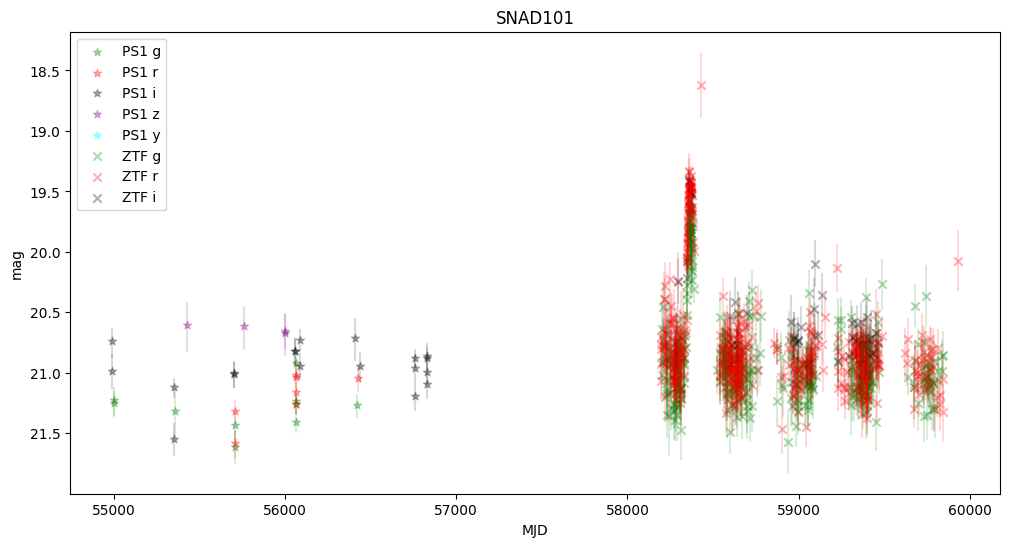

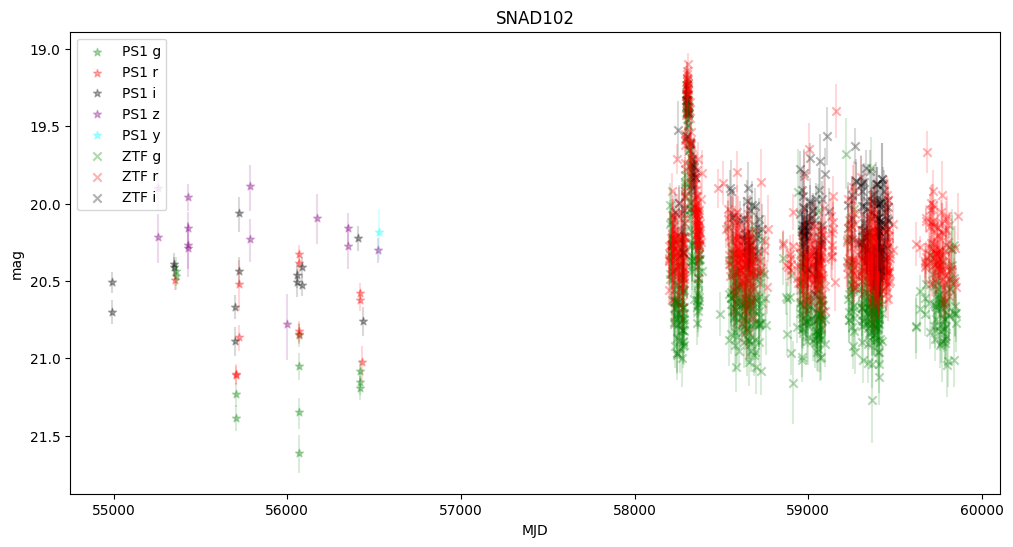

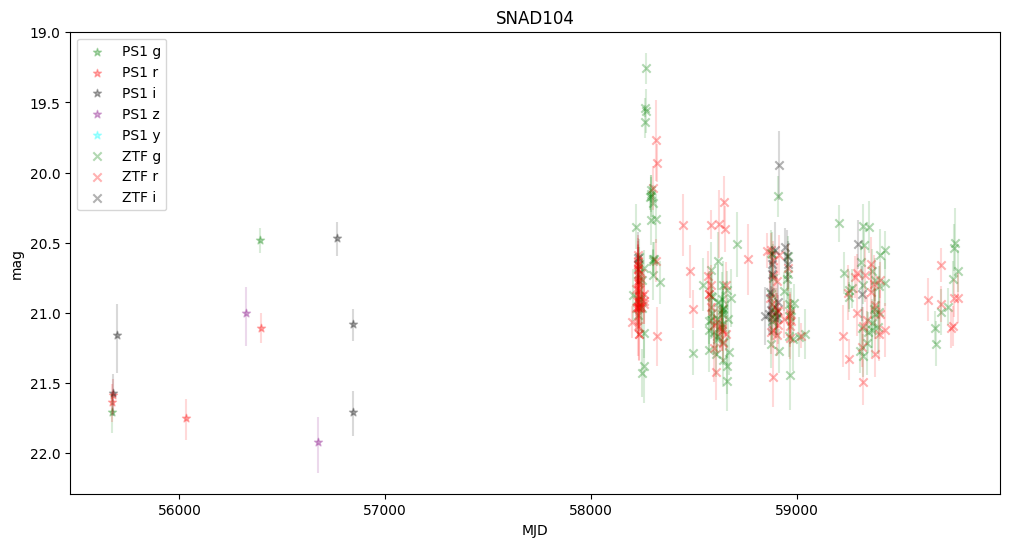

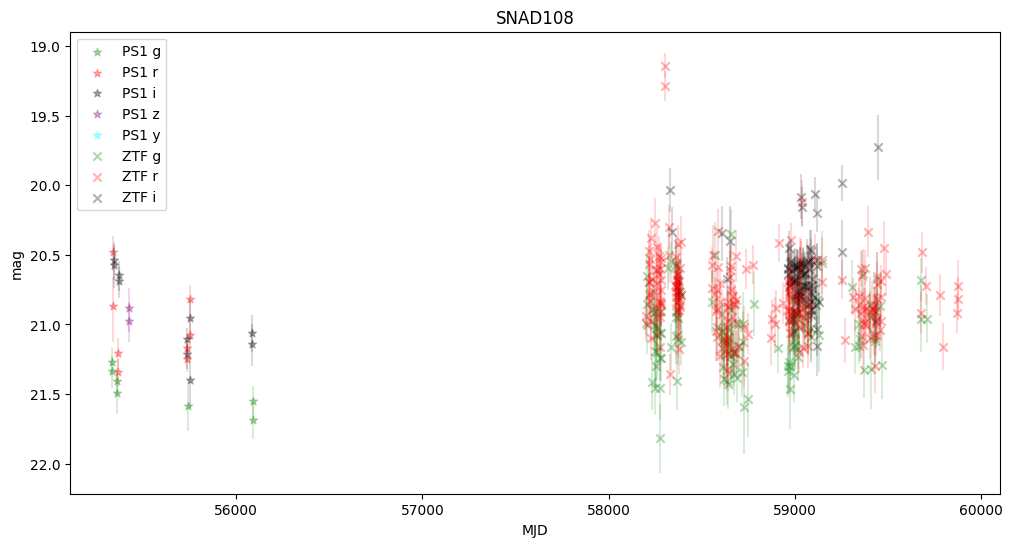

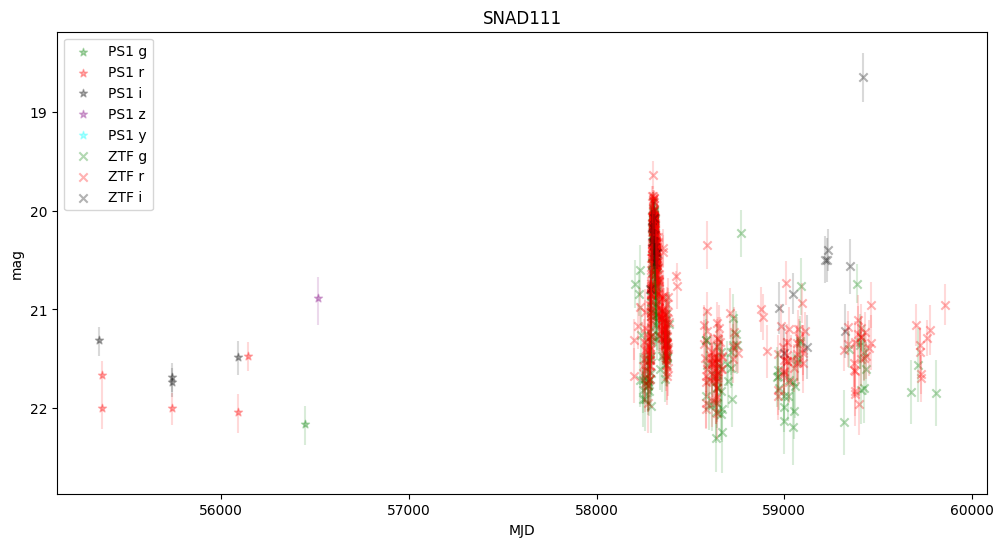

In [9]:
# Plot first five light curves

MAG_OR_FLUX = 'mag'

ps1_filter_id_to_name = dict(zip(range(1, 6), "grizy"))
get_ps1_name_from_filter_id = np.vectorize(ps1_filter_id_to_name.get)
filter_colors = {"g": "green", "r": "red", "i": "black", "z": "purple", "y": "cyan"}

ndf = ndf.sort_values("Name")

for snad_name, ps1_lc, ztf_lc in ndf.iloc[:5][["Name", "ps1_lc", "ztf_lc"]].itertuples(index=False):
    # when we iterate a nested series we are getting pandas dataframes of light curves
    plt.figure(figsize=(12, 6))

    # PS1
    ps1_bands = get_ps1_name_from_filter_id(ps1_lc["filterID"])
    for band in 'grizy':
        color = filter_colors[band]
        band_idx = ps1_bands == band
        t = ps1_lc["obsTime"][band_idx]
        flux = ps1_lc["psfFlux"][band_idx] * 1e6  # micro Jy
        err = ps1_lc["psfFluxErr"][band_idx] * 1e6
        mag = 8.9 - 2.5 * np.log10(flux / 1e6)
        mag_plus = 8.9 - 2.5 * np.log10((flux - err) / 1e6)
        mag_minus = 8.9 - 2.5 * np.log10((flux + err) / 1e6)
        if MAG_OR_FLUX == 'flux':
            plt.scatter(
                t,
                flux,
                marker='*',
                color=color,
                label=f"PS1 {band}",
                alpha=0.3,
            )
            plt.errorbar(
                t,
                flux,
                err,
                ls="",
                color=color,
                alpha=0.15,
            )
        elif MAG_OR_FLUX == 'mag':
            plt.scatter(
                t,
                mag,
                marker='*',
                color=color,
                label=f"PS1 {band}",
                alpha=0.3,
            )
            plt.errorbar(
                t,
                mag,
                [mag - mag_minus, mag_plus - mag],
                ls="",
                color=color,
                alpha=0.15,
            )
        else:
            raise ValueError(f'MAG_OR_FLUX should be mag or flux')

    # ZTF
    ztf_bands = ztf_lc["band"]
    for band in 'gri':
        band_idx = ztf_bands == band
        color = filter_colors[band]
        t = ztf_lc["mjd"][band_idx]
        mag = ztf_lc["mag"][band_idx]
        magerr = np.asarray(ztf_lc["magerr"][band_idx], dtype=float) * 1e-4
        flux = np.power(10, 0.4 * (8.9 - mag)) * 1e6  # micro Jy
        err = 0.4 * np.log(10) * flux * magerr
        if MAG_OR_FLUX == 'flux':
            plt.scatter(
                t,
                flux,
                marker='x',
                color=color,
                label=f"ZTF {band}",
                alpha=0.3,
            )
            plt.errorbar(
                t,
                flux,
                err,
                ls="",
                color=color,
                alpha=0.15,
            )
        else:
            plt.scatter(
                t,
                mag,
                marker='x',
                color=color,
                label=f"ZTF {band}",
                alpha=0.3,
            )
            plt.errorbar(
                t,
                mag,
                magerr,
                ls="",
                color=color,
                alpha=0.15,
            )
    
    plt.title(snad_name)
    plt.xlabel("MJD")
    plt.ylabel("Flux, μJy" if MAG_OR_FLUX == 'flux' else "mag")
    if MAG_OR_FLUX == 'mag':
        plt.gca().invert_yaxis()
    plt.legend(loc='upper left')